<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


<AxesSubplot: >

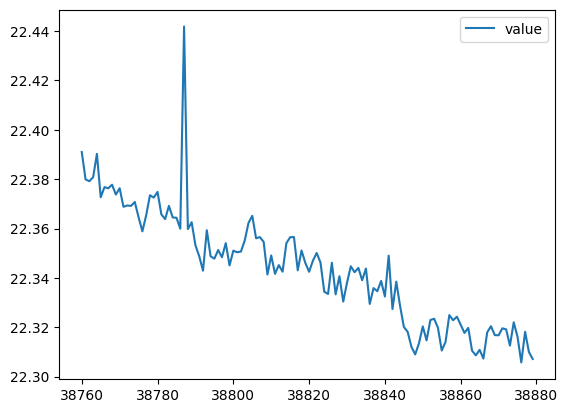

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 3
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_614287/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 1.2688550125938236 %
smape 0.4168886885272301 %
smape 0.15035627550229005 %
smape 0.14380675601998988 %
smape 0.1404291091143693 %
smape 0.12694599295827447 %
smape 0.11081863148750638 %
smape 0.10534570082492462 %
smape 0.0861736450498183 %
smape 0.10625890227734541 %
smape 0.0910128456632653 %
smape 0.07864804704243328 %
smape 0.07597278124497582 %
smape 0.07601914000465965 %
smape 0.07243437670397285 %
smape 0.0657026508614715 %
smape 0.0653370112376097 %
smape 0.0632998535248903 %
smape 0.05981152801984126 %
smape 0.0592113984918919 %
smape 0.05737075345912045 %
smape 0.05702668069269541 %
smape 0.05686486839576848 %
smape 0.05611303472096285 %
smape 0.05550325259532948 %
smape 0.05507208316039555 %
smape 0.054610106208680294 %
smape 0.05401576044921605 %
smape 0.05350354267658709 %
smape 0.053053553975582105 %
smape 0.05256183428604058 %
smape 0.05222487987573286 %
smape 0.05186889858777521 %
smape 0.05159743992259115 %
smape 0.05127496022577206 %
smape 0.0510096250473636 %


In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.0018181790651965457 %
SMAPE 0.019050253733766453 %
SMAPE 0.014650525874372987 %
SMAPE 0.0011331337051245782 %
SMAPE 0.00862307492409542 %
SMAPE 0.0490709370294553 %
SMAPE 0.01525952906507655 %
SMAPE 0.003244345679604521 %
SMAPE 0.0018168479020701511 %
SMAPE 0.007878149551913793 %
SMAPE 0.00030300936509775056 %
SMAPE 0.02518472103122349 %
SMAPE 0.030127496338536727 %
SMAPE 0.02979808136069551 %
SMAPE 0.04307794652913799 %
SMAPE 0.00675892360038688 %
SMAPE 0.006270296187281588 %
SMAPE 0.021632214858868792 %
SMAPE 0.00792450092353647 %
SMAPE 0.039505005971932405 %
SMAPE 0.04193296367213861 %
SMAPE 0.0277788961156773 %
SMAPE 0.004559736365870037 %
SMAPE 0.015400765476783818 %
SMAPE 0.0701898392954945 %
SMAPE 0.05159573494279358 %
SMAPE 0.004670080520888575 %
SMAPE 0.0291250564572465 %
SMAPE 0.023225823200071716 %
SMAPE 0.0005362025351018929 %
SMAPE 0.006403837679350488 %
SMAPE 0.022633322744638917 %
SMAPE 0.01797857262135949 %
SMAPE 0.0156163258449169 %
SMAPE 0.06931151837736138 %


SMAPE 0.00498918750673738 %
SMAPE 0.006420513126499827 %
SMAPE 0.035939825179752916 %
SMAPE 0.007033268513332303 %
SMAPE 0.001000141645043584 %
SMAPE 0.007480487512282252 %
SMAPE 0.0011166434982357032 %
SMAPE 0.005553305471742931 %
SMAPE 0.028337415528994825 %
SMAPE 0.0005076918508706285 %
SMAPE 0.0009206803252936878 %
SMAPE 0.014862195992698446 %
SMAPE 0.0282021888900772 %
SMAPE 0.004043127486966114 %
SMAPE 0.00684111683659694 %
SMAPE 0.000763099397033784 %
SMAPE 0.005552622692590603 %
SMAPE 0.0036616750410658483 %
SMAPE 0.0057259180087214645 %
SMAPE 0.007576041437175718 %
SMAPE 0.0023860741268251218 %
SMAPE 0.002819133853890321 %
SMAPE 0.0017279526617528518 %
SMAPE 0.0006243117414470589 %
SMAPE 0.004948502023069068 %
SMAPE 0.0003953262832396831 %
SMAPE 0.005880592934730089 %
SMAPE 0.016263358106726855 %
SMAPE 0.012128560947985534 %
SMAPE 0.025137618711596588 %
SMAPE 0.01984257162385461 %
SMAPE 0.01893401178216436 %
SMAPE 0.025308358372512885 %
SMAPE 0.000992573021676435 %
SMAPE 0.013

SMAPE 0.0029524447955111555 %
SMAPE 0.005740416085899369 %
SMAPE 0.04577602131308112 %
SMAPE 0.03413225888569116 %
SMAPE 0.0023144847597222906 %
SMAPE 0.0006740216467235882 %
SMAPE 0.015289362509150804 %
SMAPE 0.04722876033096668 %
SMAPE 0.03293931364305536 %
SMAPE 0.000775140507641936 %
SMAPE 0.00639651575016842 %
SMAPE 0.0050989329354962365 %
SMAPE 0.004177485084355226 %
SMAPE 0.007198045077039694 %
SMAPE 0.015840040692047808 %
SMAPE 0.023699175763397307 %
SMAPE 0.0023203529741593343 %
SMAPE 0.002277449464294534 %
SMAPE 0.03347407641291511 %
SMAPE 0.0012107505788776507 %
SMAPE 0.007058476210588083 %
SMAPE 0.004498242923332896 %
SMAPE 0.0007599050332842694 %
SMAPE 0.017597505568659244 %
SMAPE 0.013003540389931347 %
SMAPE 0.007756708593177564 %
SMAPE 0.004659731041328996 %
SMAPE 0.021822897950471543 %
SMAPE 0.001805784066505112 %
SMAPE 0.02459046888532157 %
SMAPE 0.0003303907330902689 %
SMAPE 0.01189563911665914 %
SMAPE 0.023994526729779864 %
SMAPE 0.016599998308322483 %
SMAPE 0.012418

SMAPE 0.007014873748474315 %
SMAPE 0.02782213792016108 %
SMAPE 0.03767199468284588 %
SMAPE 0.0013895927215941128 %
SMAPE 0.05774557484642173 %
SMAPE 0.0007952686923857754 %
SMAPE 0.003852998171083754 %
SMAPE 0.008118285508210477 %
SMAPE 0.000599015207583875 %
SMAPE 0.010901751696167139 %
SMAPE 0.0047740880251581075 %
SMAPE 0.001049967827270848 %
SMAPE 0.022164643811549922 %
SMAPE 0.00038631456612847614 %
SMAPE 0.001599904326099022 %
SMAPE 0.008931812748215862 %
SMAPE 0.0031810821486146774 %
SMAPE 0.009385989738426304 %
SMAPE 0.01432832910433035 %
SMAPE 0.0027627431623500343 %
SMAPE 0.013947785423397365 %
SMAPE 0.011418236675908133 %
SMAPE 0.0007566466793278437 %
SMAPE 0.035862713793790135 %
SMAPE 0.006394813888960016 %
SMAPE 0.010376539193785561 %
SMAPE 0.003022004470423667 %
SMAPE 0.060547849149259036 %
SMAPE 0.017832855304789064 %
SMAPE 0.007767672603726794 %
SMAPE 0.004706776788168554 %
SMAPE 0.002194085977421878 %
SMAPE 0.0015045967841942343 %
SMAPE 0.014626707806939978 %
SMAPE 0.0

SMAPE 0.024455422354378697 %
SMAPE 0.019371912020687887 %
SMAPE 0.018594826772527995 %
SMAPE 0.005573561932060045 %
SMAPE 0.007491103887502959 %
SMAPE 0.01614963899629629 %
SMAPE 0.001871050317348022 %
SMAPE 0.026255326767909537 %
SMAPE 0.04086851722627216 %
SMAPE 0.013911272983250456 %
SMAPE 0.0007862804784366517 %
SMAPE 0.010225949033660697 %
SMAPE 0.007758984337272068 %
SMAPE 0.0007745969473305081 %
SMAPE 0.001784924554861789 %
SMAPE 0.012932561505834883 %
SMAPE 0.00424627043562964 %
SMAPE 0.010690330252089097 %
SMAPE 0.006059634968252681 %
SMAPE 0.008459133528454288 %
SMAPE 0.0013150946895521543 %
SMAPE 0.004693006778097697 %
SMAPE 0.0027586911733123998 %
SMAPE 0.002074341833008475 %
SMAPE 0.0033865815677387445 %
SMAPE 0.0013556535825216542 %
SMAPE 0.01913861283719598 %
SMAPE 0.0008278471299334454 %
SMAPE 0.022553453534328582 %
SMAPE 0.006204069731779782 %
SMAPE 0.0007322792292967506 %
SMAPE 0.01096981476400316 %
SMAPE 0.004834865705234392 %
SMAPE 0.008940700891258757 %
SMAPE 0.008

SMAPE 0.001953444489998901 %
SMAPE 0.012783123809370522 %
SMAPE 0.006794289409214117 %
SMAPE 0.002979354456385863 %
SMAPE 0.001470185155397985 %
SMAPE 0.0018926048687859522 %
SMAPE 0.005114091201548376 %
SMAPE 0.0027436859745932907 %
SMAPE 0.0012626388475496242 %
SMAPE 0.0020945496487314585 %
SMAPE 0.002308351345391202 %
SMAPE 0.0067335234168695015 %
SMAPE 0.0011066018407746014 %
SMAPE 0.0017412814943753574 %
SMAPE 0.048909354259166093 %
SMAPE 0.017356127466861437 %
SMAPE 0.0422536169906067 %
SMAPE 0.022278772239410216 %
SMAPE 0.0017914138262398183 %
SMAPE 0.005680468849604381 %
SMAPE 0.02882456694914026 %
SMAPE 0.010637120688187451 %
SMAPE 0.0039392204386317076 %
SMAPE 0.0030101143867682367 %
SMAPE 0.019489643472468288 %
SMAPE 0.007305401666599209 %
SMAPE 0.009465428120620345 %
SMAPE 0.008685795594395529 %
SMAPE 0.01119018100727942 %
SMAPE 0.0020766082548675513 %
SMAPE 0.013523383117060916 %
SMAPE 0.010437358987189782 %
SMAPE 0.00779365074050986 %
SMAPE 0.01302205002275514 %
SMAPE 0.0

SMAPE 0.00607792476830582 %
SMAPE 0.008222066724783872 %
SMAPE 0.010704916249665075 %
SMAPE 0.016851323186017453 %
SMAPE 0.0008943081032839473 %
SMAPE 0.002416394469150873 %
SMAPE 0.005854290524410999 %
SMAPE 0.0006657542667340977 %
SMAPE 0.025527810383266566 %
SMAPE 0.004532842014214111 %
SMAPE 0.0011757937861531786 %
SMAPE 0.01863959030745832 %
SMAPE 0.011427790294185058 %
SMAPE 0.014343844387646243 %
SMAPE 0.010589049407755624 %
SMAPE 0.0056078863754009944 %
SMAPE 0.004492455959081099 %
SMAPE 0.005012501325850849 %
SMAPE 0.008037517483415968 %
SMAPE 0.0027260709569532082 %
SMAPE 0.019021962863888575 %
SMAPE 0.0010787276252699485 %
SMAPE 0.009694644523413842 %
SMAPE 0.004102648085364535 %
SMAPE 0.006508642298086897 %
SMAPE 0.0030145836785919755 %
SMAPE 0.001648936990704897 %
SMAPE 0.0017519361463627092 %
SMAPE 0.00880181464245311 %
SMAPE 0.004131756629988104 %
SMAPE 0.018484563054471437 %
SMAPE 0.03803945112714757 %
SMAPE 0.002090078540739171 %
SMAPE 0.040986524800310065 %
SMAPE 0.00

SMAPE 0.002991374642974165 %
SMAPE 0.005406434857121667 %
SMAPE 0.012161341994243458 %
SMAPE 0.006288052838229419 %
SMAPE 0.0269426134045716 %
SMAPE 0.006451286757425123 %
SMAPE 0.0008860032590405353 %
SMAPE 0.001998079364966543 %
SMAPE 0.035550600600345206 %
SMAPE 0.0026798986926053203 %
SMAPE 0.009881755357980637 %
SMAPE 0.000850833348579272 %
SMAPE 0.004472826438977506 %
SMAPE 0.0056681249686718616 %
SMAPE 0.0071252135881252334 %
SMAPE 0.01610231878743207 %
SMAPE 0.004040520978335849 %
SMAPE 0.003595834057819047 %
SMAPE 0.0007252464999112362 %
SMAPE 0.06346229268186221 %
SMAPE 0.04301137980867509 %
SMAPE 0.0018963686373325572 %
SMAPE 0.0074121395400155166 %
SMAPE 0.0010379291354354336 %
SMAPE 0.005359569733450087 %
SMAPE 0.00024117285332181382 %
SMAPE 0.05048591264721836 %
SMAPE 0.05594820826559044 %
SMAPE 0.021192741244135505 %
SMAPE 0.006841192901248405 %
SMAPE 0.0014614930142329285 %
SMAPE 0.0014728547535867165 %
SMAPE 0.007772617856346642 %
SMAPE 0.005027491193118294 %
SMAPE 0.0

SMAPE 0.028953276554986473 %
SMAPE 0.011885603875469997 %
SMAPE 0.003193156021438881 %
SMAPE 0.002333940254686695 %
SMAPE 0.043494615035328366 %
SMAPE 0.014018941868684465 %
SMAPE 0.007645219652673063 %
SMAPE 0.054944588972261954 %
SMAPE 0.0034096772765508376 %
SMAPE 0.01493123278326891 %
SMAPE 0.02477583509198666 %
SMAPE 0.012430070655682355 %
SMAPE 0.027981619575768946 %
SMAPE 0.005860722600715462 %
SMAPE 0.004650315629547208 %
SMAPE 0.004384288348916243 %
SMAPE 0.008954576556682525 %
SMAPE 0.0028698662292185873 %
SMAPE 0.00793234676928023 %
SMAPE 0.026020948931460453 %
SMAPE 0.0174248162905144 %
SMAPE 0.007977598819245202 %
SMAPE 0.009592089460277009 %
SMAPE 0.06562184325480303 %
SMAPE 0.004541994035093921 %
SMAPE 0.0006518853321892948 %
SMAPE 0.01751369040920281 %
SMAPE 0.007698213457445036 %
SMAPE 0.04170619091178196 %
SMAPE 0.0005428277321755104 %
SMAPE 0.0010487317047562783 %
SMAPE 0.05343441818973815 %
SMAPE 0.0196899955037253 %
SMAPE 0.0112210264097925 %
SMAPE 0.01824467115227

SMAPE 0.011826529357080062 %
SMAPE 0.001931111218937076 %
SMAPE 0.01266933158382244 %
SMAPE 0.029237369730793716 %
SMAPE 0.0037368117867373485 %
SMAPE 0.008940634754424082 %
SMAPE 0.032816232953422286 %
SMAPE 0.03864619783053058 %
SMAPE 0.04866649094893205 %
SMAPE 0.004282642175382989 %
SMAPE 0.0003306272541578892 %
SMAPE 0.0021101049987066745 %
SMAPE 0.003495466023316851 %
SMAPE 0.004872986525256806 %
SMAPE 0.017142872007866572 %
SMAPE 0.021427799419569737 %
SMAPE 0.018232133896901814 %
SMAPE 0.004754549344596626 %
SMAPE 0.0007590604435279147 %
SMAPE 0.018223576719492485 %
SMAPE 0.010779218107280997 %
SMAPE 0.000453551245797712 %
SMAPE 0.013087358486053803 %
SMAPE 0.019027267606652742 %
SMAPE 0.0109990466832528 %
SMAPE 0.0010899575324714306 %
SMAPE 0.012836402460095542 %
SMAPE 0.017110496566168365 %
SMAPE 0.00583232887973395 %
SMAPE 0.016874471022447324 %
SMAPE 0.036282289265159307 %
SMAPE 0.0003797040244251093 %
SMAPE 0.008696138994828573 %
SMAPE 0.0009526710809666384 %
SMAPE 0.02122

SMAPE 0.0006256450049875184 %
SMAPE 0.010600467315853734 %
SMAPE 0.03602585419713478 %
SMAPE 0.00958527802555409 %
SMAPE 0.021620842293295084 %
SMAPE 0.006055350835922013 %
SMAPE 0.006438987359615567 %
SMAPE 0.004099658947438911 %
SMAPE 0.030133203974571646 %
SMAPE 8.457386739552021 %
SMAPE 12.212703078985214 %
SMAPE 8.352888375520706 %
SMAPE 15.382640868425367 %
SMAPE 0.015182547790061564 %
SMAPE 1.7426273507298904 %
SMAPE 1.501459622828179 %
SMAPE 0.19707979401118791 %
SMAPE 0.3505787448414708 %
SMAPE 0.1120088372704231 %
SMAPE 1.5132299233227968 %
SMAPE 0.04599643078859117 %
SMAPE 0.6309928982518613 %
SMAPE 0.06847550798590873 %
SMAPE 0.3419422551360185 %
SMAPE 0.0006929262356152321 %
SMAPE 0.02893949310615085 %
SMAPE 0.028463331825960836 %
SMAPE 0.6863248853478581 %
SMAPE 0.17094777528745908 %
SMAPE 0.04876120262892414 %
SMAPE 0.012059393689753506 %
SMAPE 0.07453615472024921 %
SMAPE 0.037146778180499496 %
SMAPE 0.003191506344649042 %
SMAPE 0.16969058907102408 %
SMAPE 0.002488457464

SMAPE 0.04238839749490353 %
SMAPE 0.005199477853338408 %
SMAPE 0.06477008484807811 %
SMAPE 0.01023917171309563 %
SMAPE 0.004660895557691447 %
SMAPE 0.0035323737783485853 %
SMAPE 0.032646939485971416 %
SMAPE 0.005122170440870377 %
SMAPE 0.010719112175479495 %
SMAPE 0.0002668162849630562 %
SMAPE 0.0036207480666092806 %
SMAPE 0.012479170231316061 %
SMAPE 0.00487212341272425 %
SMAPE 0.011626770431405475 %
SMAPE 0.004812474086634211 %
SMAPE 0.028894874817524396 %
SMAPE 0.018618874544046093 %
SMAPE 0.013007048350928583 %
SMAPE 0.060527714962972816 %
SMAPE 0.004004846390365913 %
SMAPE 0.01282382630608936 %
SMAPE 0.02784219899979234 %
SMAPE 0.03618617054826245 %
SMAPE 0.0072834608389626965 %
SMAPE 0.003723908238725926 %
SMAPE 0.006195310373144025 %
SMAPE 0.009669922474046189 %
SMAPE 0.0014623322203277667 %
SMAPE 0.003917144577144427 %
SMAPE 0.0035072005513114846 %
SMAPE 0.0038262687564554203 %
SMAPE 0.003304643126995188 %
SMAPE 0.0009169212759303491 %
SMAPE 0.0005097775877018762 %
SMAPE 0.0009

SMAPE 0.01705770865987688 %
SMAPE 0.006469988468325028 %
SMAPE 0.022646055505845197 %
SMAPE 0.004559112324997727 %
SMAPE 0.012541582737426893 %
SMAPE 0.023176866525687956 %
SMAPE 0.0031647367172737972 %
SMAPE 0.047810063587576224 %
SMAPE 0.013610582964084015 %
SMAPE 0.001372805110733566 %
SMAPE 0.0026925508299768808 %
SMAPE 0.009064854117696086 %
SMAPE 0.013102262983387902 %
SMAPE 0.01664074389407233 %
SMAPE 0.07476971291612244 %
SMAPE 0.08188050741182451 %
SMAPE 0.0009302066603140702 %
SMAPE 0.001908893638436382 %
SMAPE 0.06504506864831683 %
SMAPE 0.17697026577661745 %
SMAPE 0.04094395972606435 %
SMAPE 0.017831106905212835 %
SMAPE 0.010822602809383852 %
SMAPE 0.0009740924270715822 %
SMAPE 0.0046871935409456 %
SMAPE 0.00045160078161643474 %
SMAPE 0.024051468654143093 %
SMAPE 0.07379170564138349 %
SMAPE 0.059459060191329634 %
SMAPE 0.016091214943458 %
SMAPE 0.004201477717998614 %
SMAPE 0.002241178791379639 %
SMAPE 0.0007943047765053278 %
SMAPE 0.002979913482278107 %
SMAPE 0.001800521394

SMAPE 0.03203609252159367 %
SMAPE 0.003182049490476402 %
SMAPE 0.016582204720307914 %
SMAPE 0.004527461199984373 %
SMAPE 0.0004892096047086625 %
SMAPE 0.008034967038440755 %
SMAPE 0.022417328224378252 %
SMAPE 0.047220174693393346 %
SMAPE 0.006665154487293989 %
SMAPE 0.015780500271716846 %
SMAPE 0.003024735766260278 %
SMAPE 0.0442716293255927 %
SMAPE 0.0008624275873216902 %
SMAPE 0.0069336885096333845 %
SMAPE 0.002738114725225671 %
SMAPE 0.00925021501802803 %
SMAPE 0.005178398073311996 %
SMAPE 0.004208294565593462 %
SMAPE 0.0004789016175550387 %
SMAPE 0.012420076052649165 %
SMAPE 0.00400382506818886 %
SMAPE 0.0007287713464094736 %
SMAPE 0.006064211060625269 %
SMAPE 0.11194786726264282 %
SMAPE 0.0050666392159968154 %
SMAPE 0.019836482709706615 %
SMAPE 0.07001347504910882 %
SMAPE 0.013996246989847805 %
SMAPE 0.012254273941174178 %
SMAPE 0.0035226328622641745 %
SMAPE 0.0366083861918014 %
SMAPE 0.0008034083797880953 %
SMAPE 0.0021544303514389185 %
SMAPE 0.006235926704150074 %
SMAPE 0.001175

SMAPE 0.015403333491917692 %
SMAPE 0.011385663581748418 %
SMAPE 0.0054294322593335664 %
SMAPE 0.011098004142183981 %
SMAPE 0.00870065561547051 %
SMAPE 0.020656241104120454 %
SMAPE 0.016920496279091424 %
SMAPE 0.0015269690246952907 %
SMAPE 0.0008729807097438425 %
SMAPE 0.016426045011570523 %
SMAPE 0.019834055352419 %
SMAPE 0.0006084446851204461 %
SMAPE 0.0032682691337981855 %
SMAPE 0.003431443202558171 %
SMAPE 0.015392199589683742 %
SMAPE 0.02401777259814253 %
SMAPE 0.007609094958127116 %
SMAPE 0.01608639034768089 %
SMAPE 0.008011344565233003 %
SMAPE 0.016360131127704847 %
SMAPE 0.06286235998157963 %
SMAPE 0.041437848495320395 %
SMAPE 0.026063333437946312 %
SMAPE 0.00013906828233700708 %
SMAPE 0.01635446602588786 %
SMAPE 0.001942691946830166 %
SMAPE 0.0037847132564223784 %
SMAPE 0.0005706484439400583 %
SMAPE 0.018876973967955735 %
SMAPE 0.0008982069744689624 %
SMAPE 0.023105689248218653 %
SMAPE 0.0022390709938520104 %
SMAPE 0.002667285493018312 %
SMAPE 0.0031888684848411235 %
SMAPE 0.00

SMAPE 0.006102637806122857 %
SMAPE 0.0021605939641631267 %
SMAPE 0.004458260552127058 %
SMAPE 0.008205299226929696 %
SMAPE 0.0019647812793834873 %
SMAPE 0.0037426042569279616 %
SMAPE 0.016182130726576816 %
SMAPE 0.014264749730315884 %
SMAPE 0.0038810604762318235 %
SMAPE 0.0012697282348597128 %
SMAPE 0.0033426967000877994 %
SMAPE 0.0019031242994103081 %
SMAPE 0.0013466644306632247 %
SMAPE 0.012533445680787736 %
SMAPE 0.002000236534911437 %
SMAPE 0.007712988751300997 %
SMAPE 0.0026212817226678453 %
SMAPE 0.0035649877944052837 %
SMAPE 0.007171383757530236 %
SMAPE 0.00938650902830318 %
SMAPE 0.0007762433102129762 %
SMAPE 0.0029956170102707347 %
SMAPE 0.0038649521540037313 %
SMAPE 0.010010984188284056 %
SMAPE 0.0001997030924627552 %
SMAPE 0.0021894903605357285 %
SMAPE 0.004725416797072057 %
SMAPE 0.005170913805756072 %
SMAPE 0.004071614594010953 %
SMAPE 0.0071806799102063215 %
SMAPE 0.0054097957193448565 %
SMAPE 0.009495331647428884 %
SMAPE 0.003653781154255853 %
SMAPE 0.018905748876818507 

SMAPE 0.001169372272741498 %
SMAPE 0.0005322503512630306 %
SMAPE 0.0004358519814147144 %
SMAPE 0.007574908318062512 %
SMAPE 0.007104114109040437 %
SMAPE 0.0005255027674735402 %
SMAPE 0.0006612137838857279 %
SMAPE 0.00044103461637234886 %
SMAPE 0.0017501599408547008 %
SMAPE 0.006061340859957909 %
SMAPE 0.008591834274284338 %
SMAPE 0.005304928986291202 %
SMAPE 0.044054076711859125 %
SMAPE 0.01333647864246501 %
SMAPE 0.1487473820758396 %
SMAPE 0.23042505485500442 %
SMAPE 0.021169014772681294 %
SMAPE 0.0007771894646282362 %
SMAPE 0.03825462623173337 %
SMAPE 0.0020933284880300107 %
SMAPE 0.01211612298978082 %
SMAPE 0.0009934048141531093 %
SMAPE 1.0136422328650951 %
SMAPE 1.0680815754458308 %
SMAPE 0.25760433834693686 %
SMAPE 0.002315968434743354 %
SMAPE 0.21340727128426806 %
SMAPE 0.007126583617008465 %
SMAPE 0.02144435983097992 %
SMAPE 0.009285441582115084 %
SMAPE 0.011436511918731185 %
SMAPE 0.008526838476740295 %
SMAPE 0.009191544368746918 %
SMAPE 0.008399292514269519 %
SMAPE 0.022077001

SMAPE 0.002220468427310607 %
SMAPE 0.004258956299224792 %
SMAPE 0.016449218290631507 %
SMAPE 0.0323574455421749 %
SMAPE 0.01557551320587436 %
SMAPE 0.007910716157539355 %
SMAPE 0.04923619867224716 %
SMAPE 0.0013549041309062204 %
SMAPE 0.00835051903271733 %
SMAPE 0.03356998353780227 %
SMAPE 0.0010227620673362026 %
SMAPE 0.005082080522754495 %
SMAPE 0.035036622693723984 %
SMAPE 0.0021466437813160155 %
SMAPE 0.02609243180251042 %
SMAPE 0.0039589389259759855 %
SMAPE 0.0030997405079489226 %
SMAPE 0.003975715801743718 %
SMAPE 0.03507443355096029 %
SMAPE 0.0017278908005096127 %
SMAPE 0.04625267088363216 %
SMAPE 0.0075464178425761475 %
SMAPE 0.0019139613540559708 %
SMAPE 0.01316647496804535 %
SMAPE 0.013172871914434836 %
SMAPE 0.009757070333961337 %
SMAPE 0.0065508755746463984 %
SMAPE 0.02302076452554047 %
SMAPE 0.009167911780139093 %
SMAPE 0.01766466070534989 %
SMAPE 0.0280825012551631 %
SMAPE 0.022833660769933317 %
SMAPE 0.0079018963105284 %
SMAPE 0.0017435914784158513 %
SMAPE 0.000637262670

SMAPE 0.33256328699644655 %
SMAPE 0.018823956525523045 %
SMAPE 0.15565319518032084 %
SMAPE 0.1256350712810672 %
SMAPE 0.04144047601607781 %
SMAPE 0.36255407298449427 %
SMAPE 0.06152536726085601 %
SMAPE 0.10268361618886958 %
SMAPE 0.01938905902319732 %
SMAPE 0.25149023212725297 %
SMAPE 0.2194764976229635 %
SMAPE 0.08226098827549322 %
SMAPE 0.1668715764208173 %
SMAPE 0.4335888894274831 %
SMAPE 0.2466284133906811 %
SMAPE 0.3327757668448612 %
SMAPE 0.3316957042552531 %
SMAPE 0.04350047515694655 %
SMAPE 0.3064008434421339 %
SMAPE 0.017128921190078472 %
SMAPE 0.02501266185242912 %
SMAPE 0.028053922229446467 %
SMAPE 0.3224761135643348 %
SMAPE 0.345284114649985 %
SMAPE 0.09896083602757245 %
SMAPE 0.04254132325502269 %
SMAPE 0.06021774871783237 %
SMAPE 0.0860678433975437 %
SMAPE 0.057291600799430846 %
SMAPE 0.02064791096177032 %
SMAPE 0.05535378255444812 %
SMAPE 0.19487897166936818 %
SMAPE 0.27906731593611767 %
SMAPE 0.04551439256698586 %
SMAPE 0.007134206550418298 %
SMAPE 0.1809996975307513 %


SMAPE 0.004179389575000414 %
SMAPE 0.015993489240202052 %
SMAPE 0.008074617043433818 %
SMAPE 0.014759174793027796 %
SMAPE 0.02035608950316714 %
SMAPE 0.05841739596002071 %
SMAPE 0.006865150475221071 %
SMAPE 0.01107108578381144 %
SMAPE 0.004534691102890065 %
SMAPE 0.01690262710810231 %
SMAPE 0.0007034999800126229 %
SMAPE 0.04927375944890855 %
SMAPE 0.0024236786313025505 %
SMAPE 0.0017845000614897797 %
SMAPE 0.0010693187715276053 %
SMAPE 0.0354248353330604 %
SMAPE 0.014287115315923417 %
SMAPE 0.011827262612570166 %
SMAPE 0.0006361708722977255 %
SMAPE 0.0071991464955090114 %
SMAPE 0.009957477998682407 %
SMAPE 0.0018228770773447422 %
SMAPE 0.023115547370089473 %
SMAPE 0.0026241206175328102 %
SMAPE 0.028926156534211604 %
SMAPE 0.07563004170242493 %
SMAPE 0.0008324836423412307 %
SMAPE 0.017123452449006038 %
SMAPE 0.0012467973028051915 %
SMAPE 0.0022534130893205884 %
SMAPE 0.003428728760781041 %
SMAPE 0.03099254580138222 %
SMAPE 0.015304429643634878 %
SMAPE 0.015720802580375448 %
SMAPE 0.0205

SMAPE 0.013454068403774501 %
SMAPE 0.02947993465716081 %
SMAPE 0.01958127188436265 %
SMAPE 0.0037172727697623027 %
SMAPE 0.005316079651493055 %
SMAPE 0.004568145235964494 %
SMAPE 0.011992948604813591 %
SMAPE 0.012239391410076905 %
SMAPE 0.003591732197605779 %
SMAPE 0.005249858909792238 %
SMAPE 0.005005213460322011 %
SMAPE 0.013691888846778966 %
SMAPE 0.008888850950370397 %
SMAPE 0.01342371110820295 %
SMAPE 0.003610441086152605 %
SMAPE 0.006653884453157843 %
SMAPE 0.00931213159820743 %
SMAPE 0.030936883359061085 %
SMAPE 0.00775529020512522 %
SMAPE 0.06049266128161434 %
SMAPE 0.006744272152900521 %
SMAPE 0.003633988025455892 %
SMAPE 0.03540911305856298 %
SMAPE 0.025944783443719643 %
SMAPE 0.023583232399261078 %
SMAPE 0.03124230767183178 %
SMAPE 0.03864047209427213 %
SMAPE 0.014082234776978451 %
SMAPE 0.007321970805946876 %
SMAPE 0.027508282024200525 %
SMAPE 0.027864537763832686 %
SMAPE 0.002768524995119037 %
SMAPE 0.0014169172497489058 %
SMAPE 0.001237202159039441 %
SMAPE 0.0307256958778

SMAPE 0.0023922216182512557 %
SMAPE 0.012722392599513908 %
SMAPE 0.0027887417025169725 %
SMAPE 0.0031503503422385397 %
SMAPE 0.012375223394926138 %
SMAPE 0.009739957011319689 %
SMAPE 0.0025763224350896508 %
SMAPE 0.005866691407533153 %
SMAPE 0.004528679062502761 %
SMAPE 0.005461192406826854 %
SMAPE 0.030345636043229263 %
SMAPE 0.01861248473196042 %
SMAPE 0.025805630884889297 %
SMAPE 0.010462230567554798 %
SMAPE 0.006120831881673893 %
SMAPE 0.042115831910336965 %
SMAPE 0.011819125388662144 %
SMAPE 0.04079904076775165 %
SMAPE 0.01614992081465516 %
SMAPE 0.030113192209974216 %
SMAPE 0.0008673993972934113 %
SMAPE 0.05727482317877274 %
SMAPE 0.028943484404138076 %
SMAPE 0.018773912256364156 %
SMAPE 0.01390942369351933 %
SMAPE 0.027706755207958622 %
SMAPE 0.005238508403323294 %
SMAPE 0.01800199642071476 %
SMAPE 0.05032153112580317 %
SMAPE 0.003133736776760543 %
SMAPE 0.005983147375872022 %
SMAPE 0.002983967458831671 %
SMAPE 0.00848688745620052 %
SMAPE 0.00497474688738464 %
SMAPE 0.0138634734

SMAPE 0.009849541654176619 %
SMAPE 0.0023901898720737336 %
SMAPE 0.003512588844245102 %
SMAPE 0.01099130360290701 %
SMAPE 0.001220569688726414 %
SMAPE 0.005103075950614766 %
SMAPE 0.005300681927536743 %
SMAPE 0.007193039851102867 %
SMAPE 0.007362745811917648 %
SMAPE 0.0022219241240577503 %
SMAPE 0.014165657499972895 %
SMAPE 0.0017469491693091754 %
SMAPE 0.02203270829113535 %
SMAPE 0.016058874511372778 %
SMAPE 0.0026247959283409728 %
SMAPE 0.019336218140097117 %
SMAPE 0.02847977228344689 %
SMAPE 0.008977951908448745 %
SMAPE 0.0007044065659016496 %
SMAPE 0.027489419457083386 %
SMAPE 0.02696713937064032 %
SMAPE 0.0017274265361351127 %
SMAPE 0.0012935070306241414 %
SMAPE 0.009122150951640151 %
SMAPE 0.004047135464617213 %
SMAPE 0.0030732805962543353 %
SMAPE 0.029067344784380115 %
SMAPE 0.002916079403803451 %
SMAPE 0.008772472976147583 %
SMAPE 0.04111424664961305 %
SMAPE 0.01624901346599472 %
SMAPE 0.006254935118697347 %
SMAPE 0.005852591648405792 %
SMAPE 0.009848906319675166 %
SMAPE 0.0029

SMAPE 0.02020001535015581 %
SMAPE 0.005347635332903167 %
SMAPE 0.003652115974482229 %
SMAPE 0.058116555137630144 %
SMAPE 0.00039779237013704005 %
SMAPE 0.05101431485741159 %
SMAPE 0.0033126999479407 %
SMAPE 0.0018983794955502729 %
SMAPE 0.007336708853699747 %
SMAPE 0.020769170908181422 %
SMAPE 0.013818477217796499 %
SMAPE 0.018927843371940867 %
SMAPE 0.0009127457866640043 %
SMAPE 0.0077380996347642395 %
SMAPE 0.005100806738795427 %
SMAPE 0.023187879652937227 %
SMAPE 0.005973103725139595 %
SMAPE 0.0032634984287938096 %
SMAPE 0.0019314922840010242 %
SMAPE 0.02126274998419575 %
SMAPE 0.01418396359984797 %
SMAPE 0.006885522983026249 %
SMAPE 0.007919657136568503 %
SMAPE 0.010519879100904461 %
SMAPE 0.00744420909342125 %
SMAPE 0.017029681031829114 %
SMAPE 0.01381971129961812 %
SMAPE 0.0032425946139369444 %
SMAPE 0.016779725163360126 %
SMAPE 0.005947349261418822 %
SMAPE 0.01824085405073106 %
SMAPE 0.001619267569793692 %
SMAPE 0.00034614474573402276 %
SMAPE 0.0004401940046392383 %
SMAPE 0.0253

SMAPE 0.044899118248849845 %
SMAPE 0.052824522923742734 %
SMAPE 0.0024562468945958926 %
SMAPE 0.00819482811775174 %
SMAPE 0.03066164864272025 %
SMAPE 0.014387060952955721 %
SMAPE 0.015787293036908068 %
SMAPE 0.051640568003904264 %
SMAPE 0.0013156209676026265 %
SMAPE 0.0110313820086958 %
SMAPE 0.029435331290372346 %
SMAPE 0.046558192804525333 %
SMAPE 0.0027881735414894138 %
SMAPE 0.059917303991142035 %
SMAPE 0.019268737885909104 %
SMAPE 0.005281695132097752 %
SMAPE 0.041221185997216025 %
SMAPE 0.018501516255071238 %
SMAPE 0.03579378960862556 %
SMAPE 0.024774542303241276 %
SMAPE 0.0044468808357294165 %
SMAPE 0.006715625987439466 %
SMAPE 0.031812801941725866 %
SMAPE 0.03539201678944437 %
SMAPE 0.002332472950065778 %
SMAPE 0.00029235370458025045 %
SMAPE 0.017292025625323504 %
SMAPE 0.002305386346918681 %
SMAPE 0.01482457663871628 %
SMAPE 0.0025392802758830157 %
SMAPE 0.002901099604585511 %
SMAPE 0.004134707310072372 %
SMAPE 0.013118100431746882 %
SMAPE 0.004869526659682322 %
SMAPE 0.023393

SMAPE 0.034995750960263194 %
SMAPE 0.004833579984634184 %
SMAPE 0.022583415887609704 %
SMAPE 0.0025765352814914877 %
SMAPE 0.026282354162503907 %
SMAPE 0.02415758879018881 %
SMAPE 0.025867004351653122 %
SMAPE 0.005764867757179104 %
SMAPE 0.002018413724968582 %
SMAPE 0.13138807221548632 %
SMAPE 0.003976108345781881 %
SMAPE 0.01290181767382137 %
SMAPE 0.09104143933564046 %
SMAPE 0.006052595197587607 %
SMAPE 0.07773474336272557 %
SMAPE 0.0016325342185439238 %
SMAPE 0.005373722837845207 %
SMAPE 0.0071608951824373435 %
SMAPE 0.0026652810675358296 %
SMAPE 0.029672416778339542 %
SMAPE 0.0003159513825181648 %
SMAPE 0.008003817419933057 %
SMAPE 0.01457334084804529 %
SMAPE 0.01906151894726804 %
SMAPE 0.003985339905710816 %
SMAPE 0.006656728643413602 %
SMAPE 0.0048140836469769965 %
SMAPE 0.008078963466914502 %
SMAPE 0.010891828739005405 %
SMAPE 0.016425817819765598 %
SMAPE 0.012483828272301878 %
SMAPE 0.009457152316826978 %
SMAPE 0.014432793302617597 %
SMAPE 0.007286051274590477 %
SMAPE 0.0028649

SMAPE 0.004173277270268727 %
SMAPE 0.014260313887746179 %
SMAPE 0.01878367840029682 %
SMAPE 0.009128935022886253 %
SMAPE 0.006013993832027609 %
SMAPE 0.017040114465942224 %
SMAPE 0.011333459675185509 %
SMAPE 0.00046802041381965864 %
SMAPE 0.004280061720265849 %
SMAPE 0.006831229667653816 %
SMAPE 0.004548426287286134 %
SMAPE 0.012526153623298342 %
SMAPE 0.03440310440657868 %
SMAPE 0.02661177953348215 %
SMAPE 0.034409025173772534 %
SMAPE 0.033310191972674374 %
SMAPE 0.0025052234390301464 %
SMAPE 0.014374070692113605 %
SMAPE 0.01363499293252346 %
SMAPE 0.0117597516085155 %
SMAPE 0.003281267611654925 %
SMAPE 0.010060400365262012 %
SMAPE 0.002228922208175277 %
SMAPE 0.01103306634294654 %
SMAPE 0.0029632776286518947 %
SMAPE 0.003474129750301813 %
SMAPE 0.0022871472410770366 %
SMAPE 0.013818997205248708 %
SMAPE 0.00596198083169952 %
SMAPE 0.0032773726299097916 %
SMAPE 0.0029331267887044987 %
SMAPE 0.00827181312095604 %
SMAPE 0.017607970547970808 %
SMAPE 0.007556359125160839 %
SMAPE 0.00547952

SMAPE 0.0035021887019013325 %
SMAPE 0.024624601172305915 %
SMAPE 0.004066000944163761 %
SMAPE 0.003153800940296492 %
SMAPE 0.01748015809388903 %
SMAPE 0.003507692023553943 %
SMAPE 0.005506866006939504 %
SMAPE 0.004115334683575611 %
SMAPE 0.009423982226820726 %
SMAPE 0.0008433256443964865 %
SMAPE 0.003644344652954601 %
SMAPE 0.0327821169003073 %
SMAPE 0.0015618778944599399 %
SMAPE 0.005087370002456737 %
SMAPE 0.010438371329037466 %
SMAPE 0.01300385062755538 %
SMAPE 0.0009504047731923038 %
SMAPE 0.03323938365912227 %
SMAPE 0.004478036918442285 %
SMAPE 0.003152400753904771 %
SMAPE 0.04939690015544329 %
SMAPE 0.01799436852628844 %
SMAPE 0.024841483485090524 %
SMAPE 0.014857921040743351 %
SMAPE 0.004946047524043706 %
SMAPE 0.03777120875423634 %
SMAPE 0.02892936629552878 %
SMAPE 0.023494306986634683 %
SMAPE 0.028186005665418176 %
SMAPE 0.0012479406516945346 %
SMAPE 0.011024901417158617 %
SMAPE 0.03448643174420596 %
SMAPE 0.0018355416727899865 %
SMAPE 0.016352149493400248 %
SMAPE 0.0166946956

SMAPE 0.000334725718104778 %
SMAPE 0.01617961777265009 %
SMAPE 0.004733050149411611 %
SMAPE 0.0056194270290461645 %
SMAPE 0.0033708398246261595 %
SMAPE 0.008882065533498462 %
SMAPE 0.002380775834751603 %
SMAPE 0.0031304774578160277 %
SMAPE 0.008645851966903706 %
SMAPE 0.005895790596106565 %
SMAPE 0.012258679685800189 %
SMAPE 0.015835911679403125 %
SMAPE 0.008841378325371352 %
SMAPE 0.010636979420866055 %
SMAPE 0.0004554125346203364 %
SMAPE 0.010434051104596165 %
SMAPE 0.0011412530978702762 %
SMAPE 0.004247228746464771 %
SMAPE 0.005344575637352023 %
SMAPE 0.006437961753022137 %
SMAPE 0.007449866736521925 %
SMAPE 0.005362865676801221 %
SMAPE 0.000992966694056463 %
SMAPE 0.0024351579333838913 %
SMAPE 0.006049580903976448 %
SMAPE 0.005236708262884804 %
SMAPE 0.004347889825282891 %
SMAPE 0.0023103982467063133 %
SMAPE 0.0004676391285727277 %
SMAPE 0.0009991898157863943 %
SMAPE 0.007720060601421609 %
SMAPE 0.0054112113774351656 %
SMAPE 0.019034531893140638 %
SMAPE 0.004215083346394977 %
SMAPE

SMAPE 0.0016181241242776423 %
SMAPE 0.007133437666325904 %
SMAPE 0.000648066179778084 %
SMAPE 0.006367392316860787 %
SMAPE 0.0003039782267748592 %
SMAPE 0.01651609873457005 %
SMAPE 0.0014621784932131732 %
SMAPE 0.002708934466582491 %
SMAPE 0.002884085245540291 %
SMAPE 0.008910542438826496 %
SMAPE 0.003934233270229015 %
SMAPE 0.0077791998171790055 %
SMAPE 0.002461601413642711 %
SMAPE 0.00022502166793714193 %
SMAPE 0.0021249612948395225 %
SMAPE 0.004281874840032174 %
SMAPE 0.004987351908070536 %
SMAPE 0.003939240626991136 %
SMAPE 0.0006056269432050954 %
SMAPE 0.0014193255589844966 %
SMAPE 0.0018977753340578831 %
SMAPE 0.005200864032609331 %
SMAPE 0.0014292150210053478 %
SMAPE 0.007626798290431224 %
SMAPE 0.0036320504384832475 %
SMAPE 0.0006550469851873686 %
SMAPE 0.0005027962096448846 %
SMAPE 0.0020649523079896426 %
SMAPE 0.006474851130462866 %
SMAPE 0.0020166986659972963 %
SMAPE 0.0059575354367780164 %
SMAPE 0.0023215134170584406 %
SMAPE 0.006173091911449547 %
SMAPE 0.000829333983233482

SMAPE 0.0019862569693316345 %
SMAPE 0.0009757895006998751 %
SMAPE 0.0056245180670799755 %
SMAPE 0.003230772231837875 %
SMAPE 0.003999222106870093 %
SMAPE 0.0051854247889053795 %
SMAPE 0.0252781726643434 %
SMAPE 0.012659677736337471 %
SMAPE 0.017644849079914593 %
SMAPE 0.006107950787168193 %
SMAPE 0.009552084425763496 %
SMAPE 0.005826791111388729 %
SMAPE 0.003920489431003205 %
SMAPE 0.003464388232487181 %
SMAPE 0.006619405416415703 %
SMAPE 0.0038474414909543957 %
SMAPE 0.0016445575996755224 %
SMAPE 0.0024869320182290267 %
SMAPE 0.004868314090266779 %
SMAPE 0.013906858550569723 %
SMAPE 0.006261724882087094 %
SMAPE 0.0073901831427463085 %
SMAPE 0.0067830316230725884 %
SMAPE 0.0062501011754534375 %
SMAPE 0.003795614826799465 %
SMAPE 0.002943487960180846 %
SMAPE 0.0017512065988896097 %
SMAPE 0.0008130893367876979 %
SMAPE 0.0010444917058691772 %
SMAPE 0.002661131451247911 %
SMAPE 0.004181406681880162 %
SMAPE 0.0019373410866876386 %
SMAPE 0.007846023663702795 %
SMAPE 0.027412163476327578 %
SM

SMAPE 0.004264777947881271 %
SMAPE 0.0018119941030789735 %
SMAPE 0.006024686654349409 %
SMAPE 0.0006050471512608624 %
SMAPE 0.0056310670959334175 %
SMAPE 0.004117577890710322 %
SMAPE 0.004864893820013094 %
SMAPE 0.002495207159377344 %
SMAPE 0.002464737932598382 %
SMAPE 0.0007810153519756113 %
SMAPE 0.003879669505174377 %
SMAPE 0.021170122514519107 %
SMAPE 0.006330939110938517 %
SMAPE 0.007267483841047806 %
SMAPE 0.0021544802198647517 %
SMAPE 0.00021212608755405427 %
SMAPE 0.0007195386640006518 %
SMAPE 0.0037888258399476626 %
SMAPE 0.003429900128310237 %
SMAPE 0.0048136592436165415 %
SMAPE 0.0023835351821617223 %
SMAPE 0.005398718313372797 %
SMAPE 0.0022578716702952306 %
SMAPE 0.001404262369376852 %
SMAPE 0.0042575656787704474 %
SMAPE 0.00043683710266151365 %
SMAPE 0.0009155063835493138 %
SMAPE 0.008013900927757334 %
SMAPE 0.007887503170152854 %
SMAPE 0.005987537795732578 %
SMAPE 0.0016396355482086733 %
SMAPE 0.002773747664306825 %
SMAPE 0.002360520301891711 %
SMAPE 0.001237639344637386

SMAPE 0.006560560035310914 %
SMAPE 0.0005420204782211613 %
SMAPE 0.006742095676798955 %
SMAPE 0.00959346512512127 %
SMAPE 0.021454938372897914 %
SMAPE 0.00233262059396111 %
SMAPE 0.00043512685817859165 %
SMAPE 0.00020800875145710052 %
SMAPE 0.018639801695840674 %
SMAPE 0.014593253759898062 %
SMAPE 0.00888681478531339 %
SMAPE 0.0031937300587117075 %
SMAPE 0.001074682864484089 %
SMAPE 0.0004353676593353839 %
SMAPE 0.0014647786891330838 %
SMAPE 0.0018776226569912067 %
SMAPE 0.005142720972258985 %
SMAPE 0.0014775006254410528 %
SMAPE 0.0012356074624193525 %
SMAPE 0.0023788202396417546 %
SMAPE 0.0003440447440254957 %
SMAPE 0.003386236839418189 %
SMAPE 0.006111082148947844 %
SMAPE 0.0020687901010632004 %
SMAPE 0.012173543306346346 %
SMAPE 0.003161742471093021 %
SMAPE 0.0012698365246421872 %
SMAPE 0.007217589919605416 %
SMAPE 0.0003581968823098691 %
SMAPE 0.011311215155956234 %
SMAPE 0.0027928715885607858 %
SMAPE 0.00013070679824522813 %
SMAPE 0.0058674482060041555 %
SMAPE 0.006207014373444509

SMAPE 0.0022345151123275286 %
SMAPE 0.000768866893608333 %
SMAPE 0.0009392696392396261 %
SMAPE 0.004068342324771379 %
SMAPE 0.014290277483354432 %
SMAPE 0.007528627619080907 %
SMAPE 0.007530512223780762 %
SMAPE 0.006549526461583356 %
SMAPE 0.00035796347419392305 %
SMAPE 0.0017849487017542744 %
SMAPE 0.0008597289055956027 %
SMAPE 0.004809346972841411 %
SMAPE 0.0033896438849652104 %
SMAPE 0.008124157669840315 %
SMAPE 0.006332081264595502 %
SMAPE 0.002861642579830459 %
SMAPE 0.004440717429019969 %
SMAPE 0.004981024767232611 %
SMAPE 0.0013661234612385442 %
SMAPE 0.006762479688532608 %
SMAPE 0.0024920337521336933 %
SMAPE 0.006958726240100077 %
SMAPE 0.016000554786586463 %
SMAPE 0.0030634528363862046 %
SMAPE 0.0037077329716908025 %
SMAPE 0.0009689009038851282 %
SMAPE 0.004190000714764608 %
SMAPE 0.004313350548493133 %
SMAPE 0.0015149779813157238 %
SMAPE 0.0020225965384241817 %
SMAPE 0.011819369834434212 %
SMAPE 0.006562841755410886 %
SMAPE 0.018996736756406563 %
SMAPE 0.01161582863807098 %
S

SMAPE 0.014747447080182496 %
SMAPE 0.0040473114279393485 %
SMAPE 0.0010575309541636102 %
SMAPE 0.005398461746580097 %
SMAPE 0.0060291491131536645 %
SMAPE 0.0032028852197640845 %
SMAPE 0.001736603921671076 %
SMAPE 0.0005991358551895587 %
SMAPE 0.010330835524484883 %
SMAPE 0.0021699752275026185 %
SMAPE 0.005073950942488636 %
SMAPE 0.0009410116212649201 %
SMAPE 0.0005782073636524387 %
SMAPE 0.006997713930303461 %
SMAPE 0.0011534994394821751 %
SMAPE 0.003258409443787969 %
SMAPE 0.001845917867967728 %
SMAPE 0.0010231175430206463 %
SMAPE 0.0007952988720489884 %
SMAPE 0.0007058836575168925 %
SMAPE 0.007677285047577698 %
SMAPE 0.004141758172920618 %
SMAPE 0.003665350782114274 %
SMAPE 0.0039596219863824444 %
SMAPE 0.0008621154147050448 %
SMAPE 0.0005222711659627066 %
SMAPE 0.002277543607192456 %
SMAPE 0.004336398635587102 %
SMAPE 0.005158940936915712 %
SMAPE 0.005388194625666642 %
SMAPE 0.0006645584049067566 %
SMAPE 0.004777358116371033 %
SMAPE 0.0072633809760276336 %
SMAPE 0.006067339901335345

SMAPE 0.00038383032667610445 %
SMAPE 0.0015023467729662343 %
SMAPE 0.0005481751990146222 %
SMAPE 0.0050652709720395706 %
SMAPE 0.002545033078398262 %
SMAPE 0.0005493680769674825 %
SMAPE 0.001496822965698641 %
SMAPE 0.001191418564346236 %
SMAPE 0.003379645696583111 %
SMAPE 0.0012274926914415119 %
SMAPE 0.0032737438764200984 %
SMAPE 0.0005715442092508738 %
SMAPE 0.005933400033768521 %
SMAPE 0.0004176562289615049 %
SMAPE 0.0015198420659388034 %
SMAPE 0.0007861936580866313 %
SMAPE 0.008282043344230772 %
SMAPE 0.0020514455252396147 %
SMAPE 0.00048106647729184715 %
SMAPE 0.004781584642856274 %
SMAPE 0.0034412381327086905 %
SMAPE 0.0020013743761353453 %
SMAPE 0.0012426484503578195 %
SMAPE 0.0019507040145470003 %
SMAPE 0.00042768961868944183 %
SMAPE 0.0008111368576493305 %
SMAPE 0.0024215917238876727 %
SMAPE 0.0035693963951217707 %
SMAPE 0.0010580228582881546 %
SMAPE 0.0024982919456704167 %
SMAPE 0.0010547799480917774 %
SMAPE 0.019650618753772164 %
SMAPE 0.23260628874413666 %
SMAPE 0.185374059

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[22.395267486572266,
 22.393077850341797,
 22.41409683227539,
 22.39293670654297,
 22.459684371948242,
 22.42981719970703,
 22.40520477294922,
 22.403629302978516,
 22.394487380981445,
 22.41533851623535,
 22.398061752319336,
 22.392318725585938,
 22.450448989868164,
 22.45102310180664,
 22.4158935546875,
 22.40506362915039,
 22.398685455322266,
 22.430261611938477,
 22.452186584472656,
 22.38361358642578,
 22.45904541015625,
 22.39875602722168,
 22.39040184020996,
 22.457792282104492,
 22.375205993652344,
 22.419658660888672,
 22.391752243041992,
 22.43203353881836,
 22.42116355895996,
 22.420894622802734,
 22.380083084106445,
 22.430513381958008,
 22.42821502685547,
 22.364017486572266,
 22.40315055847168,
 22.44698715209961,
 22.403587341308594,
 22.38585090637207,
 22.456134796142578,
 22.397478103637695,
 22.381515502929688,
 22.457326889038086,
 22.363296508789062,
 22.356632232666016,
 22.395368576049805,
 22.3963565826416,
 22.39774513244629,
 22.461687088012695,
 22.3847446441

In [19]:
target=list(target.values.reshape(-1))

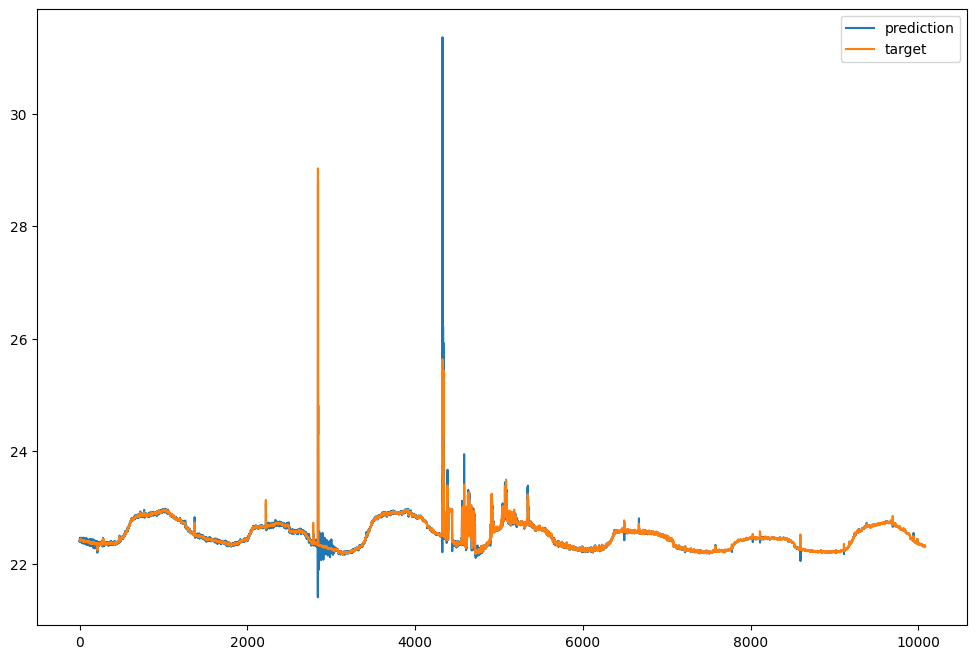

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([22.39526749, 22.39307785, 22.41409683, ..., 22.30484009,
       22.31876945, 22.30925941])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.09819046827033162 %
RMSE 0.1105690449476242
MAPE 0.09829429909586906 %


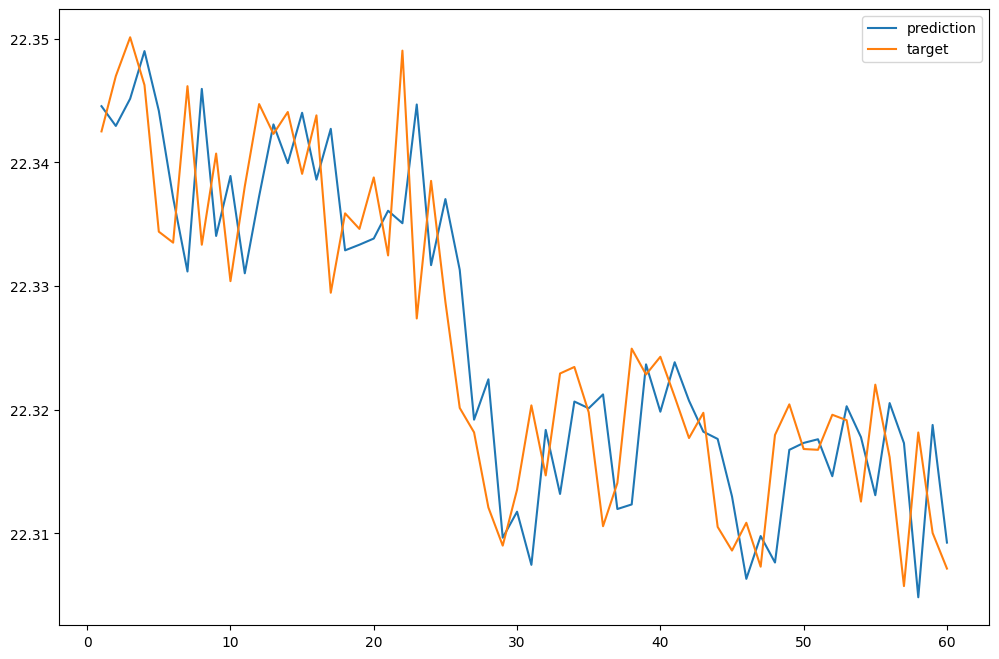

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.35729763808231507